# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Patuh Rujhan Al Istizhar
- **Email:** patuh41@gmail.com
- **ID Dicoding:** patuh_istizhar

## Import Semua Packages/Library yang Digunakan

In [ ]:
import datetime
import json
import os
import random
import shutil

import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import splitfolders
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)
from tensorflow.keras.layers import (
    BatchNormalization,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Preparation

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Define constants
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50

### Data Loading


== Data Loading ==
Path to dataset files: /kaggle/input/garbage-classification-v2
Classes in dataset: ['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic']
DataFrame sample:
                                           filepaths   labels
0  /kaggle/input/garbage-classification-v2/garbag...  battery
1  /kaggle/input/garbage-classification-v2/garbag...  battery
2  /kaggle/input/garbage-classification-v2/garbag...  battery
3  /kaggle/input/garbage-classification-v2/garbag...  battery
4  /kaggle/input/garbage-classification-v2/garbag...  battery

Class distribution:
labels
clothes       5327
glass         3061
plastic       1984
shoes         1977
cardboard     1825
paper         1680
metal         1020
biological     997
trash          947
battery        944
Name: count, dtype: int64


<ipython-input-3-f4ea5632ef1d>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


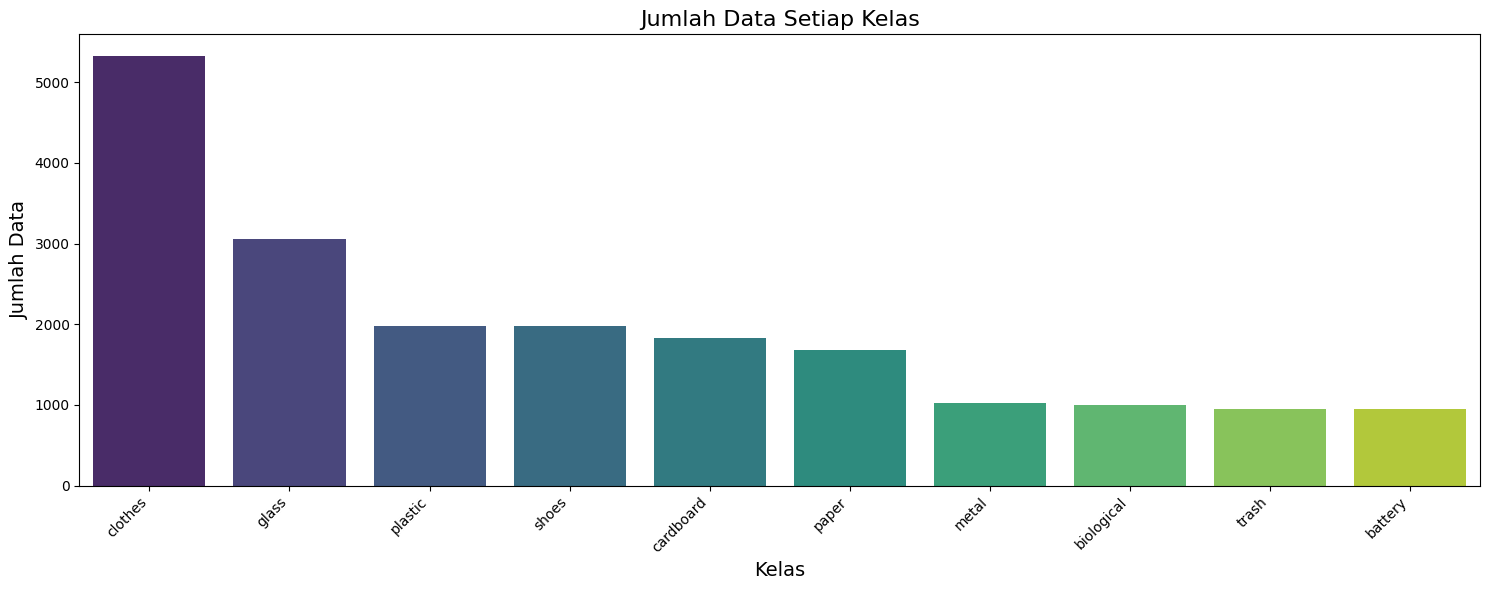

In [ ]:
# Download latest version
path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")
print("Path to dataset files:", path)

# Define base directory for the dataset
base_dir = os.path.join(path, "garbage-dataset")
print("Classes in dataset:", os.listdir(base_dir))

# Create dataframe with filepaths and labels
filepaths = []
labels = []
classlist = sorted(os.listdir(base_dir))

for klass in classlist:
    classpath = os.path.join(base_dir, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)

print("DataFrame sample:")
print(df.head())

print("\nClass distribution:")
class_counts = df["labels"].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(15, 6))
# Modified - removed the single bar chart
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Jumlah Data Setiap Kelas", fontsize=16)
plt.xlabel("Kelas", fontsize=14)
plt.ylabel("Jumlah Data", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Data Preprocessing


== Data Preprocessing ==
Preprocessing images...
Processed 100/19762 images...
Processed 200/19762 images...
Processed 300/19762 images...
Processed 400/19762 images...
Processed 500/19762 images...
Processed 600/19762 images...
Processed 700/19762 images...
Processed 800/19762 images...
Processed 900/19762 images...
Processed 1000/19762 images...
Processed 1100/19762 images...
Processed 1200/19762 images...
Processed 1300/19762 images...
Processed 1400/19762 images...
Processed 1500/19762 images...
Processed 1600/19762 images...
Processed 1700/19762 images...
Processed 1800/19762 images...
Processed 1900/19762 images...
Processed 2000/19762 images...
Processed 2100/19762 images...
Processed 2200/19762 images...
Processed 2300/19762 images...
Processed 2400/19762 images...
Processed 2500/19762 images...
Processed 2600/19762 images...
Processed 2700/19762 images...
Processed 2800/19762 images...
Processed 2900/19762 images...
Processed 3000/19762 images...
Processed 3100/19762 images..

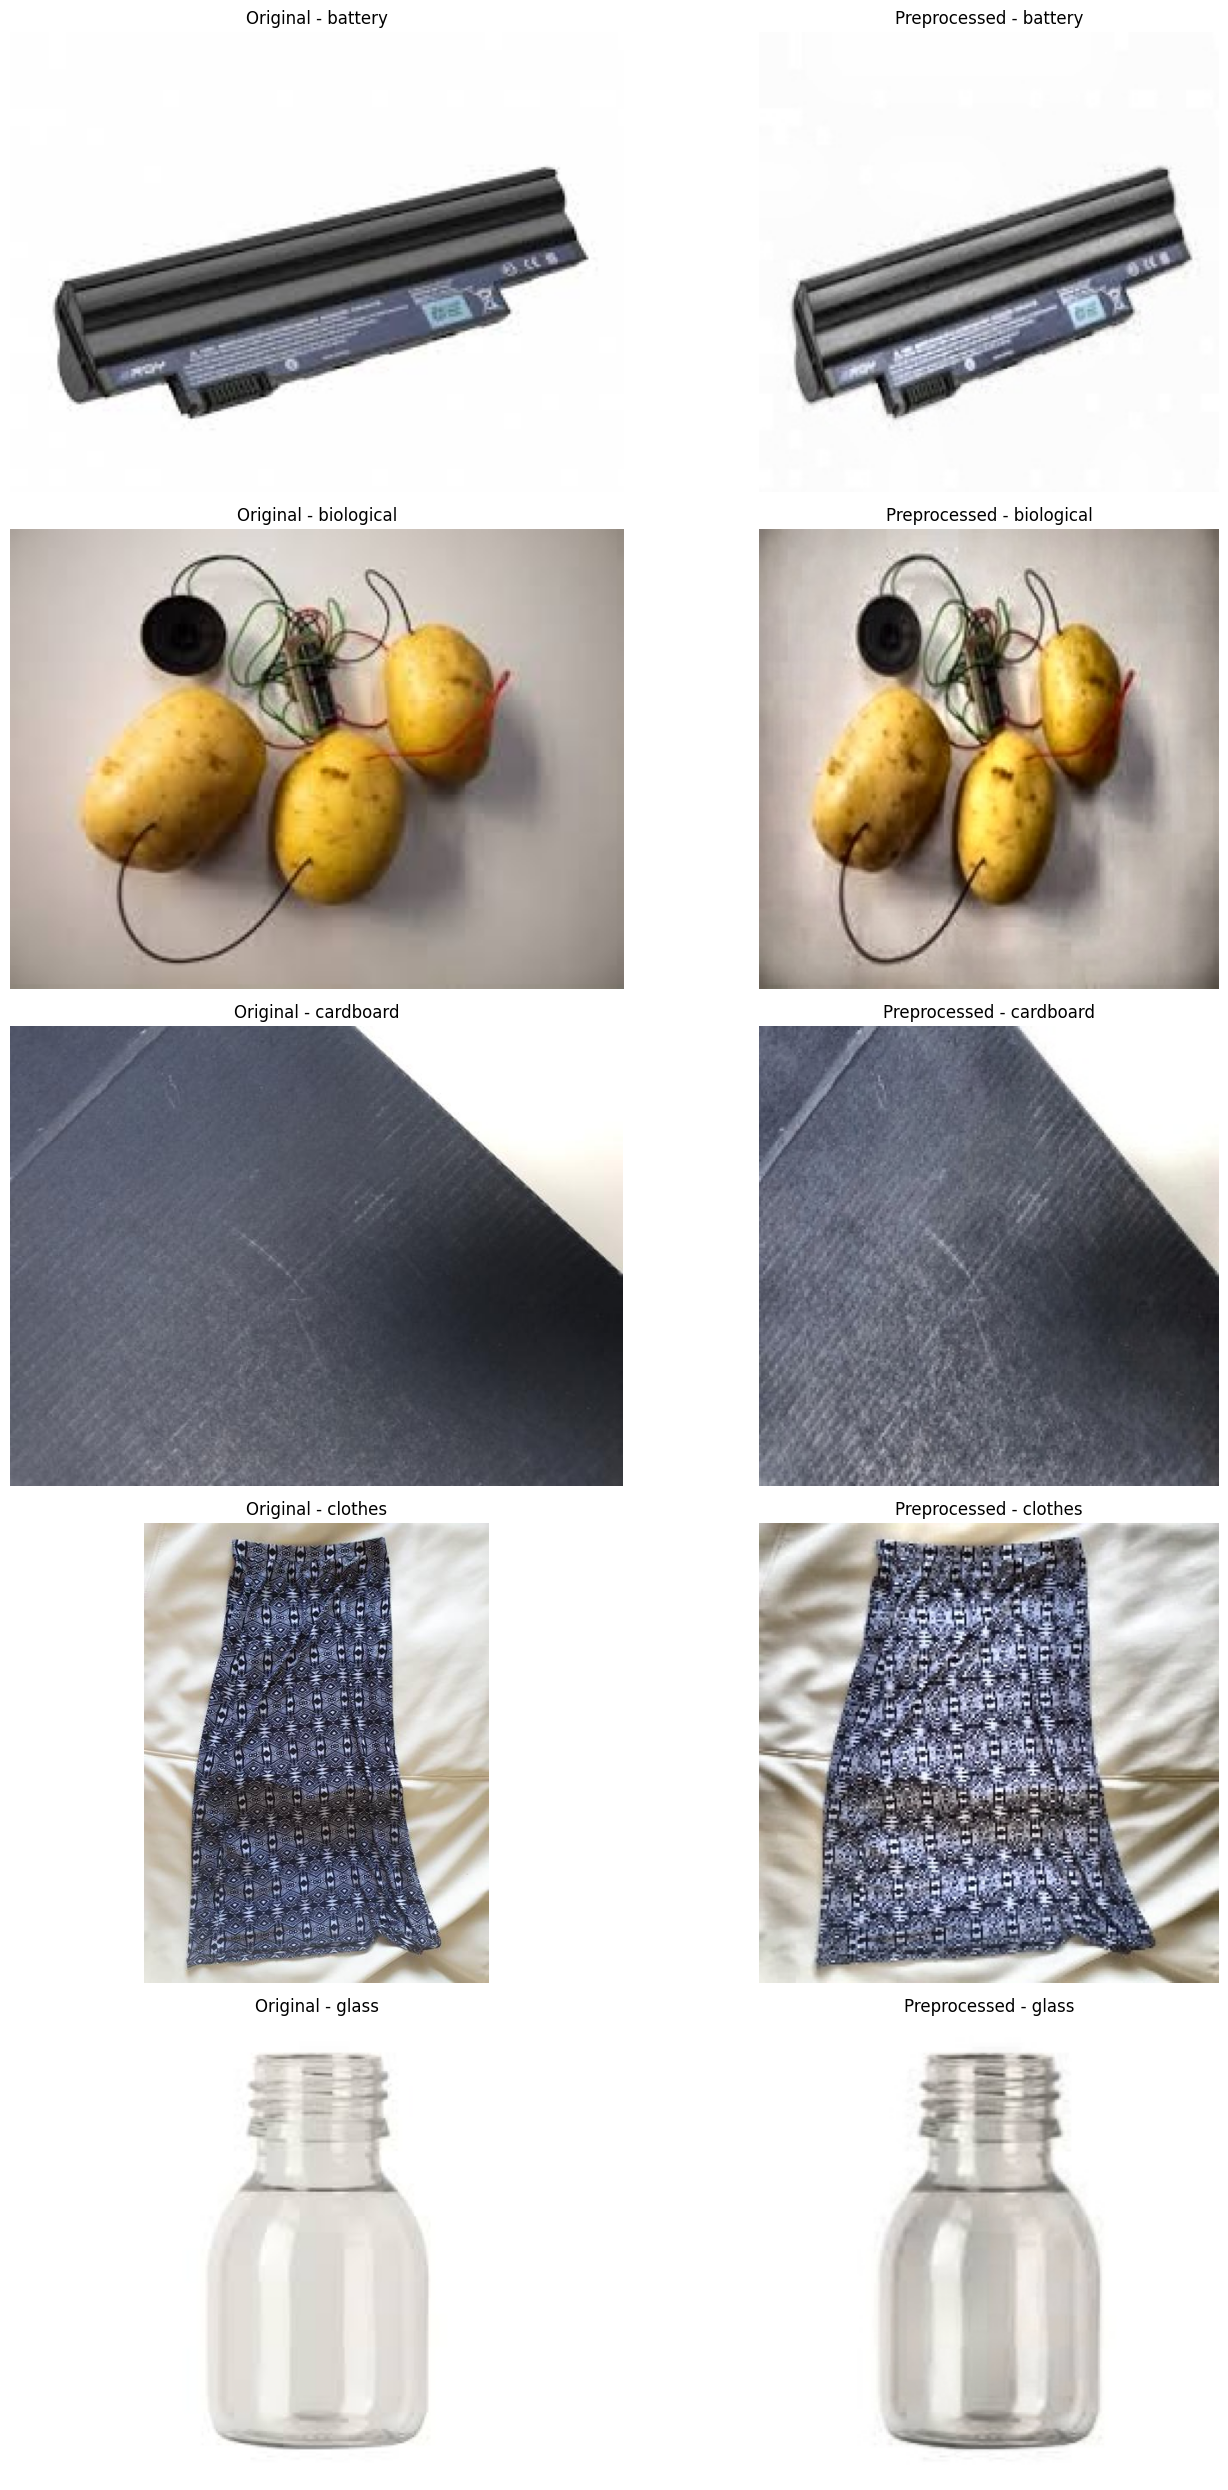

In [4]:
print("\n== Data Preprocessing ==")

# Create a directory for preprocessed images
preprocessed_dir = "preprocessed_dataset"
if os.path.exists(preprocessed_dir):
    shutil.rmtree(preprocessed_dir)
os.makedirs(preprocessed_dir)

# Create class directories
for class_name in classlist:
    os.makedirs(os.path.join(preprocessed_dir, class_name), exist_ok=True)


# Function to preprocess images
def preprocess_image(img_path, target_size=(IMG_SIZE, IMG_SIZE)):
    # Read image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error reading image: {img_path}")
        return None

    # Convert to RGB (OpenCV uses BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize image
    img = cv2.resize(img, target_size)

    # Apply some basic preprocessing
    # 1. Normalize pixel values
    img = img / 255.0

    # 2. Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    lab = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB) / 255.0

    # 3. Convert back to 0-255 range and uint8 type for saving
    img = (img * 255).astype(np.uint8)

    return img


# Process images and save them to the preprocessed directory
print("Preprocessing images...")
total_images = len(df)
processed_count = 0
error_count = 0

for _, row in df.iterrows():
    img_path = row["filepaths"]
    label = row["labels"]

    # Preprocess the image
    processed_img = preprocess_image(img_path)

    if processed_img is not None:
        # Generate output filename
        img_filename = os.path.basename(img_path)
        output_path = os.path.join(preprocessed_dir, label, img_filename)

        # Save the processed image
        cv2.imwrite(output_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        processed_count += 1
    else:
        error_count += 1

    # Print progress
    if processed_count % 100 == 0:
        print(f"Processed {processed_count}/{total_images} images...")

print(
    f"Preprocessing complete! {processed_count} images processed, {error_count} errors."
)


# Display examples of original vs preprocessed images
def display_comparison(original_paths, processed_dir, num_examples=3):
    plt.figure(figsize=(15, 5 * num_examples))

    for i, orig_path in enumerate(original_paths[:num_examples]):
        # Original image
        orig_img = cv2.imread(orig_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

        # Preprocessed image
        label = os.path.basename(os.path.dirname(orig_path))
        img_filename = os.path.basename(orig_path)
        proc_path = os.path.join(processed_dir, label, img_filename)

        if os.path.exists(proc_path):
            proc_img = cv2.imread(proc_path)
            proc_img = cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB)

            # Display images
            plt.subplot(num_examples, 2, 2 * i + 1)
            plt.imshow(orig_img)
            plt.title(f"Original - {label}", fontsize=12)
            plt.axis("off")

            plt.subplot(num_examples, 2, 2 * i + 2)
            plt.imshow(proc_img)
            plt.title(f"Preprocessed - {label}", fontsize=12)
            plt.axis("off")

    plt.tight_layout()
    plt.show()


# Show some examples
sample_images = []
for class_name in classlist:
    class_samples = df[df["labels"] == class_name]["filepaths"].sample(
        min(1, sum(df["labels"] == class_name))
    )
    sample_images.extend(class_samples.tolist())

display_comparison(
    sample_images, preprocessed_dir, num_examples=min(5, len(sample_images))
)

#### Split Dataset


== Splitting Dataset ==


Copying files: 19762 files [00:03, 6121.68 files/s]


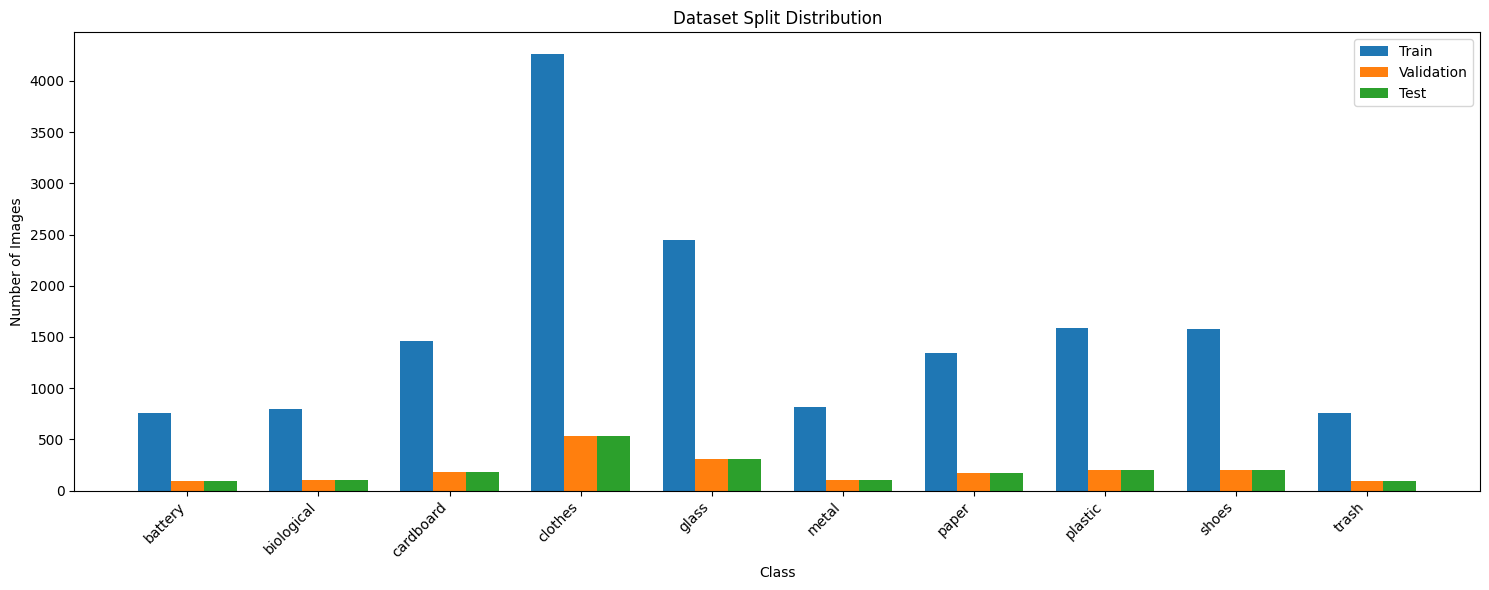

Train set: 15806 images
Validation set: 1972 images
Test set: 1984 images
Found 15806 images belonging to 10 classes.
Found 1972 images belonging to 10 classes.
Found 1984 images belonging to 10 classes.
Class indices: {'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}
Number of classes: 10


In [5]:
print("\n== Splitting Dataset ==")
output_folder = "split_dataset"

# Remove output folder if it exists
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Split the preprocessed dataset
splitfolders.ratio(
    preprocessed_dir, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1)
)

# Verify the split
train_dir = os.path.join(output_folder, "train")
val_dir = os.path.join(output_folder, "val")
test_dir = os.path.join(output_folder, "test")

train_counts = []
val_counts = []
test_counts = []
class_names = []

for class_name in classlist:
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    if (
        os.path.exists(train_class_dir)
        and os.path.exists(val_class_dir)
        and os.path.exists(test_class_dir)
    ):
        train_count = len(os.listdir(train_class_dir))
        val_count = len(os.listdir(val_class_dir))
        test_count = len(os.listdir(test_class_dir))

        train_counts.append(train_count)
        val_counts.append(val_count)
        test_counts.append(test_count)
        class_names.append(class_name)

# Plot the split distribution
plt.figure(figsize=(15, 6))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, train_counts, width, label="Train")
plt.bar(x, val_counts, width, label="Validation")
plt.bar(x + width, test_counts, width, label="Test")

plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Dataset Split Distribution")
plt.xticks(x, class_names, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Train set: {sum(train_counts)} images")
print(f"Validation set: {sum(val_counts)} images")
print(f"Test set: {sum(test_counts)} images")

# Create data generators
train_datagen = ImageDataGenerator(
    # We already preprocessed images, but apply augmentation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest",
)

# No augmentation for validation and test
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

# Display class indices
print(f"Class indices: {train_generator.class_indices}")
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

# Save class indices for later
class_indices = train_generator.class_indices
with open("class_indices.json", "w") as f:
    json.dump(class_indices, f)

# Create a dictionary mapping indices to class labels
idx_to_class = {v: k for k, v in class_indices.items()}


## Modelling

In [ ]:
def create_model(input_shape, num_classes):
    base_model = EfficientNetB0(
        input_shape=input_shape, include_top=False, weights="imagenet"
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Create new model on top
    model = Sequential(
        [
            # Base pre-trained model
            base_model,
            # Add custom layers on top
            GlobalAveragePooling2D(),
            # First dense layer
            Dense(512, activation="relu"),
            BatchNormalization(),
            Dropout(0.5),
            # Second dense layer
            Dense(256, activation="relu"),
            BatchNormalization(),
            Dropout(0.3),
            # Output layer
            Dense(num_classes, activation="softmax"),
        ]
    )

    return model


# Create model
model = create_model((IMG_SIZE, IMG_SIZE, 3), num_classes)
model.summary()

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Simpler learning rate for transfer learning
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Set up callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    ModelCheckpoint(
        "best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6),
    TensorBoard(log_dir=log_dir, histogram_freq=1),
]

# Change training to implement fine-tuning after some initial epochs
# Train the model with base layers frozen first
print("\nTraining model with frozen base layers...")
initial_epochs = 15  # Reduced epochs for initial training
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=initial_epochs,
    callbacks=callbacks,
    verbose=1,
)

# Unfreeze some layers for fine-tuning
print("\nUnfreezing top layers of the base model for fine-tuning...")
# Unfreeze the top layers of the base model
base_model = model.layers[0]
base_model.trainable = True

# Freeze all the layers except the top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Fine-tune the model
print("\nFine-tuning the model...")
total_epochs = initial_epochs + 20  # Train for additional epochs
fine_tune_history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    callbacks=callbacks,
    verbose=1,
)

# Combine histories for plotting
history.history["accuracy"].extend(fine_tune_history.history["accuracy"])
history.history["val_accuracy"].extend(fine_tune_history.history["val_accuracy"])
history.history["loss"].extend(fine_tune_history.history["loss"])
history.history["val_loss"].extend(fine_tune_history.history["val_loss"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,842,413 (18.47 MB)

 Trainable params: 791,306 (3.02 MB)

 Non-trainable params: 4,051,107 (15.45 MB)


Training model with frozen base layers...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
494/494 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.7859 - loss: 0.7155
Epoch 1: val_accuracy improved from -inf to 0.92698, saving model to best_model.keras
494/494 ━━━━━━━━━━━━━━━━━━━━ 239s 432ms/step - accuracy: 0.7861 - loss: 0.7150 - val_accuracy: 0.9270 - val_loss: 0.2255 - learning_rate: 0.0010
Epoch 2/15
343/494 ━━━━━━━━━━━━━━━━━━━━ 56s 372ms/step - accuracy: 0.8975 - loss: 0.3162

## Evaluasi dan Visualisasi

In [ ]:
# Evaluasi dan Visualisasi
print("\n=== EVALUASI DAN VISUALISASI ===")

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc * 100:.2f}%)")

# Extract training history
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Plot training & validation accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.axhline(y=0.95, color="r", linestyle="--", label="Target (95%)")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Print best accuracy values
best_val_acc = max(val_acc)
best_train_acc = max(train_acc)
print(f"\nBest Training Accuracy: {best_train_acc:.4f} ({best_train_acc * 100:.2f}%)")
print(f"Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc * 100:.2f}%)")

# Check if target accuracy is achieved
if best_train_acc < 0.95 or test_acc < 0.95:
    print("\nWARNING: Target accuracy of 95% not achieved!")
    print("Consider adjusting model architecture or training parameters.")
else:
    print("\nSUCCESS: Target accuracy of 95% achieved for both training and test sets!")

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(class_indices.keys()),
    yticklabels=list(class_indices.keys()),
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(
    classification_report(
        y_true, y_pred_classes, target_names=list(class_indices.keys())
    )
)


# Display some example predictions
def display_predictions(generator, model, class_indices, num_images=10):
    # Get class labels
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Get batch of images
    batch = next(generator)
    images, labels = batch

    # Make predictions
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    # Display images with predictions
    plt.figure(figsize=(15, num_images * 2))

    for i in range(min(num_images, len(images))):
        plt.subplot(num_images // 2, 2, i + 1)
        plt.imshow(images[i])

        # Check if prediction is correct
        is_correct = pred_classes[i] == true_classes[i]
        color = "green" if is_correct else "red"

        # Get class names
        pred_class_name = idx_to_class[pred_classes[i]]
        true_class_name = idx_to_class[true_classes[i]]

        plt.title(
            f"Prediction: {pred_class_name}\nTrue: {true_class_name}",
            color=color,
            fontsize=12,
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Display some test predictions
test_batch_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=10,
    class_mode="categorical",
    shuffle=True,
)
display_predictions(test_batch_generator, model, class_indices)


## Konversi Model

In [ ]:
print("\n=== KONVERSI MODEL ===")

# 1. Save model in SavedModel format
savedmodel_path = "savedmodel"
tf.saved_model.save(model, savedmodel_path)
print(f"Model saved in SavedModel format at: {savedmodel_path}")


# 2. Convert to TensorFlow Lite
def convert_to_tflite(model, quantize=False):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    if quantize:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

    tflite_model = converter.convert()

    # Save the TFLite model
    model_name = "model_quantized.tflite" if quantize else "model.tflite"
    with open(model_name, "wb") as f:
        f.write(tflite_model)

    print(f"TFLite model saved as: {model_name}")
    return tflite_model


# Convert to TFLite (standard)
tflite_model = convert_to_tflite(model)

# Convert to TFLite (quantized)
tflite_model_quantized = convert_to_tflite(model, quantize=True)

# 3. Convert to TensorFlow.js format
tfjs_path = "tfjs_model"
if os.path.exists(tfjs_path):
    shutil.rmtree(tfjs_path)

# The conversion requires tensorflowjs package
# Install it if needed: !pip install tensorflowjs
try:
    import tensorflowjs as tfjs

    tfjs.converters.save_keras_model(model, tfjs_path)
    print(f"TensorFlow.js model saved at: {tfjs_path}")
except ImportError:
    print("tensorflowjs package not found. Install with: pip install tensorflowjs")


## Inference (Optional)

In [ ]:
print("\n=== INFERENCE ===")


def load_and_preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Preprocess (similar to our training preprocessing)
    img = img / 255.0

    # Add batch dimension
    img = np.expand_dims(img, axis=0)

    return img


def predict_image(model, image_path, class_indices):
    # Load and preprocess the image
    img = load_and_preprocess_image(image_path)

    # Make prediction
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Get class name
    idx_to_class = {v: k for k, v in class_indices.items()}
    predicted_class = idx_to_class[predicted_class_index]

    # Get confidence
    confidence = predictions[0][predicted_class_index]

    return predicted_class, confidence, predictions[0]


# Select a few test images
test_images = []
for class_name in classlist:
    class_dir = os.path.join(test_dir, class_name)
    if os.path.exists(class_dir):
        # Get list of files
        files = os.listdir(class_dir)
        if files:
            # Select one random file
            test_image = os.path.join(class_dir, random.choice(files))
            test_images.append((test_image, class_name))

# Perform inference on the test images
for image_path, true_class in test_images:
    predicted_class, confidence, all_scores = predict_image(
        model, image_path, class_indices
    )

    # Print results
    print(f"\nImage: {os.path.basename(image_path)}")
    print(f"True Class: {true_class}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")

    # Display image with prediction
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    color = "green" if predicted_class == true_class else "red"
    plt.title(
        f"Prediction: {predicted_class} ({confidence:.2%})\nTrue: {true_class}",
        color=color,
        fontsize=14,
    )
    plt.axis("off")
    plt.show()

    # Display probability distribution
    plt.figure(figsize=(10, 3))
    plt.bar(list(class_indices.keys()), all_scores)
    plt.title("Class Probabilities")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

print("\nGarbage Classification Model Pipeline Complete!")